In [622]:
import numpy as np
import scipy as sp
import math
import skimage as ski
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
import cupy as cp
from cupyx.scipy import ndimage

In [623]:
test_data = np.zeros(shape=[500,500])

In [624]:
#fill columns

def relative_distances(matrix, reference_point, radius):
    # Get the shape of the matrix
    rows, cols = matrix.shape
    
    # Create an array of coordinates for each point in the matrix
    row_indices, col_indices = np.indices((rows, cols))
    
    # Calculate the Euclidean distance for each point with respect to the reference point
    distances = np.sqrt((row_indices - reference_point[0])**2 + (col_indices - reference_point[1])**2)
    result_matrix = np.where(distances >= radius, 0, 1)
        
    return result_matrix


rods_radius = 20
#set rods coordinates
for i in range(0,2):
    #fill rows
    for j in range(0,6):
        x, y = (i+1)*150, (j+1)*65
        reference_point = [y,x]
        test_data += relative_distances(test_data, reference_point, rods_radius)
    

In [625]:
def mask_data(matrix, radius):
    rows, cols = matrix.shape
    
    # Create an array of coordinates for each point in the matrix
    row_indices, col_indices = np.indices((rows, cols))
    
    # Calculate the Euclidean distance for each point with respect to the reference point
    distances = np.sqrt((row_indices - 250)**2 + (col_indices - 250)**2)
    result_matrix = np.where(distances >= radius, 0, 1)
    return matrix*result_matrix


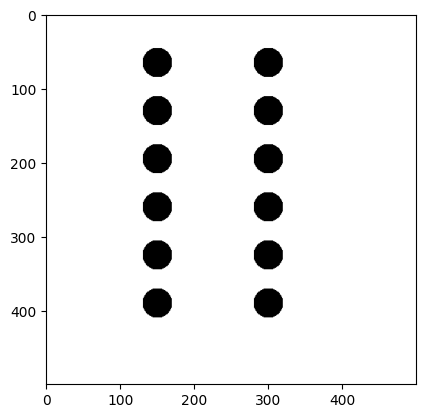

In [626]:
#make a copy for a second energy:

test_data_final = np.zeros_like(test_data)

#assign data values (linear attenuation coefficients)
pixel_size = 50e-4 #in cm

mu1, rho1 = 3, 4.26 #~TiO2 at 25 keV
mu2, rho2 = 6e-1, 1 #~Soft tissue at 25 keV

noe = 100
#for i in range(0,noe):
#    mu1, rho1 = 3, 4.26 #~TiO2 at 25 keV
#    mu2, rho2 = 6e-1, 1 #~Soft tissue at 25 keV
#    test_data_final += np.where(test_data >= 0.5, math.exp(-pixel_size*rho1*mu1*(noe-i)), 
#                                                math.exp(-pixel_size*rho2*mu2*(noe-i)))

test_data = np.where(test_data >= 0.5, np.exp(-pixel_size*rho1*mu1), 
                                              np.exp(-pixel_size*rho2*mu2))

#test_data = test_data_final/noe


plt.imshow(test_data,cmap='gray')
#plt.axhline(1,150,color='r')

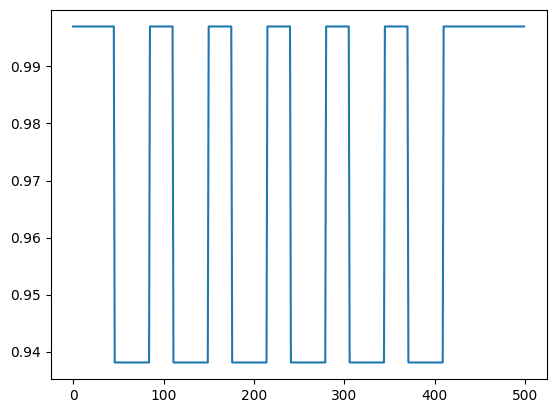

In [627]:
plt.plot(test_data[:,150])
plt.show()

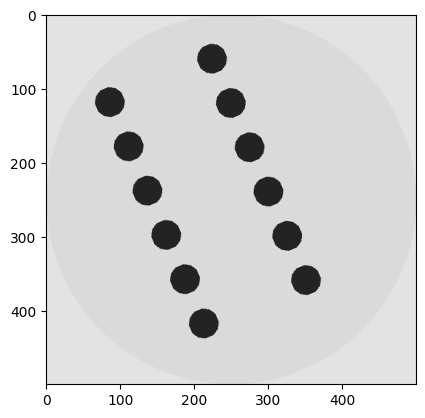

In [628]:
#Introduce arbitrary matrix rotation
arb_rot_angle = 23
test_data = cp.asnumpy(ndimage.rotate(cp.array(test_data), 23, axes=(0, 1), reshape=False))
#test_data = test_data[~np.isnan(test_data)]
#test_data -= np.min(test_data)

#Masking data again
test_data = mask_data(test_data,250)
#Remove zeros in intensities
test_data[test_data == 0] = 1.0
#Visualize
plt.imshow(test_data,cmap='gray')

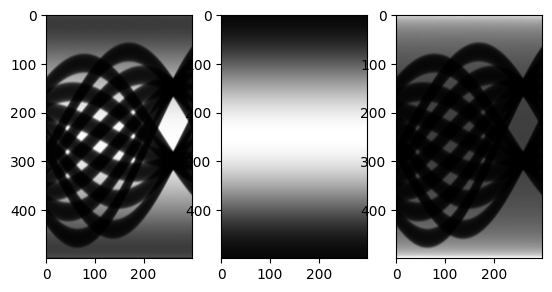

In [629]:
#create sinogram with simple rotation
#COnsiders the signal in INTESITY, therefore uses multiplication instead of sum
angles = 300
theta = np.linspace(0,180,angles)


sino_rot = np.zeros(shape=[len(theta), 500])
l = 0

from cupyx.scipy import ndimage
for el in theta:
    temp = mask_data(cp.asnumpy(ndimage.rotate(cp.array(test_data), 
                                               theta[l], axes=(0, 1), 
                                               reshape=False)),
                                               250)
    temp[temp == 0] = 1.0
    sino_rot[l,] = math.prod(temp)
    l += 1

sino_rot = np.rot90(sino_rot,1)


#Normalize data
#sino_rot /= np.max(sino_rot)

#Add poisson noise
#noise_mask = np.random.poisson(sino_rot)
#sino_rot = sino_rot + noise_mask*0.1


#Simulate windowing
sino_rot = sp.ndimage.uniform_filter(sino_rot, [wsize, 0], mode='constant')
#mask = rng.binomial(1, 0.95, sino.shape)
#sino_rot *= mask
sino_rot *= sp.signal.get_window('hamming', sino_rot.shape[0])[:, None]

#Simulate white field normalization
flat_fields = np.ones_like(sino_rot)

flat_fields = sp.ndimage.uniform_filter(flat_fields, [wsize, 0], mode='constant')
flat_fields *= sp.signal.get_window('hamming', flat_fields.shape[0])[:, None]

#Display results
fig,ax = plt.subplots(1, 3)#, figsize=(16,4))
ax[0].imshow(sino_rot,cmap='gray')
ax[1].imshow(flat_fields,cmap='gray')
ax[2].imshow(sino_rot/flat_fields,cmap='gray')

#Do the job
sino_rot /= flat_fields 

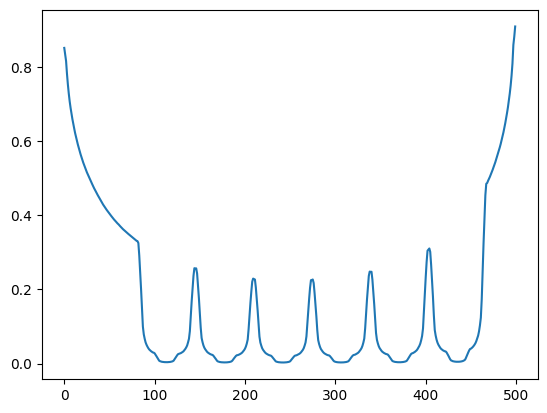

In [630]:
plt.plot(sino_rot[:,100])
plt.show()

angles = 300
seed = 0

rng = np.random.default_rng(seed)
psnr, wsize = 20, 10
#fig,ax = plt.subplots(1, 2, figsize=(16,4))

def NumberOfAngles(angles):
    ideal_sino = ski.transform.radon(test_data, theta=np.linspace(0, 180, angles), circle=True)

    sino = sp.ndimage.uniform_filter(ideal_sino, [wsize, 0], mode='constant')
    #mask = rng.binomial(1, 0.95, sino.shape)
    #sino *= mask
    sino *= sp.signal.get_window('hamming', sino.shape[0])[:, None]
    plt.imshow(sino,cmap='gray')
    
interact(NumberOfAngles, angles=widgets.IntSlider(min=1,max=1000,step=1,value=500));


angles = 300
seed = 0

rng = np.random.default_rng(seed)
psnr, wsize = 20, 5 

ideal_sino = ski.transform.radon(test_data, theta=np.linspace(0, 180, angles), circle=True)

sino = sp.ndimage.uniform_filter(ideal_sino, [wsize, 0], mode='constant')
#mask = rng.binomial(1, 0.95, sino.shape)
#sino *= mask
sino *= sp.signal.get_window('hamming', sino.shape[0])[:, None]


In [631]:
#Simulate correction for bad pixels
sino_rot[sino_rot == 0] = np.mean(sino_rot)


#min_val = 0
def SlideRanger(min_val,max_val):
    #print(min_val, max_val)
    fbp = ski.transform.iradon(radon_image=-np.log(sino_rot), filter_name="hamming")
    if max_val <= min_val:
        max_val = min_val + 0.01
    plt.imshow(fbp,vmin=min_val, vmax=max_val, cmap='gray')#vmin = -1000, vmax = -2,
        
interact(SlideRanger, min_val=widgets.FloatSlider(min=-3,max=3,step=0.01,value=0),
                      max_val=widgets.FloatSlider(min=-3,max=3,step=0.01,value=0));

interactive(children=(FloatSlider(value=0.0, description='min_val', max=3.0, min=-3.0, step=0.01), FloatSlider…